In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 786.78it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:18<00:00, 15.07img/s]

***
Unet Loss: 0.6285161972045898     Segnet Loss: 0.7302061319351196     Enet Loss: 0.9444955587387085
Voting Loss: 0.7677392959594727


Epoch 1/50:  99%|█████████▊| 200/203 [00:24<00:00,  8.05img/s]

---
Unet Validation Dice Score: 0.3851238489151001     Segnet Validation Dice Score: 0.08063826709985733     Enet Validation Dice Score: 0.21931703388690948
---
Ensemble Voting Validation Dice Loss: 1.0265901883443196
Ensemble Voting Validation Pixel Accuracy: 0.8408987480297423 
Ensemble Voting Validation MIoU: 0.5422104149149166
Ensemble Voting Validation Dice Score: 0.4402075409889221 



Epoch 2/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.5454568862915039     Segnet Loss: 0.4214584231376648     Enet Loss: 0.8585726618766785
Voting Loss: 0.6084959904352824


Epoch 2/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
Unet Validation Dice Score: 0.7674372792243958     Segnet Validation Dice Score: 0.7265955805778503     Enet Validation Dice Score: 0.22260864078998566
---
Ensemble Voting Validation Dice Loss: 0.6954934597015381
Ensemble Voting Validation Pixel Accuracy: 0.9300919917591831 
Ensemble Voting Validation MIoU: 0.7773618107327227
Ensemble Voting Validation Dice Score: 0.7830231785774231 



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.44img/s]

***
Unet Loss: 0.49070775508880615     Segnet Loss: 0.30926382541656494     Enet Loss: 0.8063039779663086
Voting Loss: 0.5354251861572266


Epoch 3/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.07img/s]

---
Unet Validation Dice Score: 0.815860390663147     Segnet Validation Dice Score: 0.6953850984573364     Enet Validation Dice Score: 0.23833313584327698
---
Ensemble Voting Validation Dice Loss: 0.5996989409128824
Ensemble Voting Validation Pixel Accuracy: 0.92755126953125 
Ensemble Voting Validation MIoU: 0.7617742771251416
Ensemble Voting Validation Dice Score: 0.7986472249031067 



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.4195517897605896     Segnet Loss: 0.3006267547607422     Enet Loss: 0.7564842700958252
Voting Loss: 0.492220938205719


Epoch 4/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
Unet Validation Dice Score: 0.8446782231330872     Segnet Validation Dice Score: 0.7841171622276306     Enet Validation Dice Score: 0.24013970792293549
---
Ensemble Voting Validation Dice Loss: 0.5111316839853922
Ensemble Voting Validation Pixel Accuracy: 0.9455387048554003 
Ensemble Voting Validation MIoU: 0.8175195753056022
Ensemble Voting Validation Dice Score: 0.835174024105072 



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.84img/s]

***
Unet Loss: 0.3797432482242584     Segnet Loss: 0.25271719694137573     Enet Loss: 0.69517982006073
Voting Loss: 0.4425467550754547


Epoch 5/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.86img/s]

---
Unet Validation Dice Score: 0.7784521579742432     Segnet Validation Dice Score: 0.8007872700691223     Enet Validation Dice Score: 0.24447624385356903
---
Ensemble Voting Validation Dice Loss: 0.5285468896230062
Ensemble Voting Validation Pixel Accuracy: 0.9315000835217928 
Ensemble Voting Validation MIoU: 0.7952011759063571
Ensemble Voting Validation Dice Score: 0.8018245697021484 



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.38275784254074097     Segnet Loss: 0.23649148643016815     Enet Loss: 0.632353663444519
Voting Loss: 0.4172009974718094


Epoch 6/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.81img/s]

---
Unet Validation Dice Score: 0.8237873315811157     Segnet Validation Dice Score: 0.8346244692802429     Enet Validation Dice Score: 0.2863093912601471
---
Ensemble Voting Validation Dice Loss: 0.46019041538238525
Ensemble Voting Validation Pixel Accuracy: 0.9466268974438048 
Ensemble Voting Validation MIoU: 0.8302955381021173
Ensemble Voting Validation Dice Score: 0.8519272804260254 



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
Unet Loss: 0.3310909867286682     Segnet Loss: 0.21396133303642273     Enet Loss: 0.6698294281959534
Voting Loss: 0.40496058265368146


Epoch 7/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.73img/s]

---
Unet Validation Dice Score: 0.8552568554878235     Segnet Validation Dice Score: 0.8413681983947754     Enet Validation Dice Score: 0.32505783438682556
---
Ensemble Voting Validation Dice Loss: 0.4092643658320109
Ensemble Voting Validation Pixel Accuracy: 0.9458936724746436 
Ensemble Voting Validation MIoU: 0.8271956552428723
Ensemble Voting Validation Dice Score: 0.8621529936790466 



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.38img/s]

***
Unet Loss: 0.2863420844078064     Segnet Loss: 0.1759430468082428     Enet Loss: 0.575950562953949
Voting Loss: 0.3460785647233327


Epoch 8/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.92img/s]

---
Unet Validation Dice Score: 0.8616108298301697     Segnet Validation Dice Score: 0.817879319190979     Enet Validation Dice Score: 0.34741804003715515
---
Ensemble Voting Validation Dice Loss: 0.38458089033762616
Ensemble Voting Validation Pixel Accuracy: 0.9492008142304003 
Ensemble Voting Validation MIoU: 0.8307952884451115
Ensemble Voting Validation Dice Score: 0.8507272601127625 



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.296269029378891     Segnet Loss: 0.17424383759498596     Enet Loss: 0.5714426636695862
Voting Loss: 0.34731851021448773


Epoch 9/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
Unet Validation Dice Score: 0.8342611193656921     Segnet Validation Dice Score: 0.864734947681427     Enet Validation Dice Score: 0.36444559693336487
---
Ensemble Voting Validation Dice Loss: 0.37615489959716797
Ensemble Voting Validation Pixel Accuracy: 0.9496733012952303 
Ensemble Voting Validation MIoU: 0.8327252258489721
Ensemble Voting Validation Dice Score: 0.8742521405220032 



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.78img/s]

***
Unet Loss: 0.2705782353878021     Segnet Loss: 0.12914429605007172     Enet Loss: 0.5330140590667725
Voting Loss: 0.3109121968348821


Epoch 10/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.83img/s]

---
Unet Validation Dice Score: 0.8764420747756958     Segnet Validation Dice Score: 0.8782364726066589     Enet Validation Dice Score: 0.3793428838253021
---
Ensemble Voting Validation Dice Loss: 0.3340873718261719
Ensemble Voting Validation Pixel Accuracy: 0.9572424637643915 
Ensemble Voting Validation MIoU: 0.8495451883014453
Ensemble Voting Validation Dice Score: 0.8933022618293762 



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.22488778829574585     Segnet Loss: 0.14403459429740906     Enet Loss: 0.5260241031646729
Voting Loss: 0.29831549525260925


Epoch 11/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.8639054298400879     Segnet Validation Dice Score: 0.8304986357688904     Enet Validation Dice Score: 0.3979334533214569
---
Ensemble Voting Validation Dice Loss: 0.32984628280003864
Ensemble Voting Validation Pixel Accuracy: 0.9568302087616503 
Ensemble Voting Validation MIoU: 0.8550523940301431
Ensemble Voting Validation Dice Score: 0.8460143208503723 



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.18341609835624695     Segnet Loss: 0.1161019429564476     Enet Loss: 0.4674742519855499
Voting Loss: 0.2556640977660815


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.00img/s]

---
Unet Validation Dice Score: 0.878513514995575     Segnet Validation Dice Score: 0.8608962297439575     Enet Validation Dice Score: 0.4186875820159912
---
Ensemble Voting Validation Dice Loss: 0.3250358502070109
Ensemble Voting Validation Pixel Accuracy: 0.9462989673279879 
Ensemble Voting Validation MIoU: 0.8232457114703551
Ensemble Voting Validation Dice Score: 0.8810808062553406 



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
Unet Loss: 0.1918860822916031     Segnet Loss: 0.13414114713668823     Enet Loss: 0.48975786566734314
Voting Loss: 0.27192836503187817


Epoch 13/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.86img/s]

---
Unet Validation Dice Score: 0.8607047200202942     Segnet Validation Dice Score: 0.8598233461380005     Enet Validation Dice Score: 0.4478079378604889
---
Ensemble Voting Validation Dice Loss: 0.33027346928914386
Ensemble Voting Validation Pixel Accuracy: 0.9502210115131579 
Ensemble Voting Validation MIoU: 0.8385873762481435
Ensemble Voting Validation Dice Score: 0.8685114979743958 



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.16600453853607178     Segnet Loss: 0.08374358713626862     Enet Loss: 0.44503530859947205
Voting Loss: 0.23159447809060416


Epoch 14/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.97img/s]

---
Unet Validation Dice Score: 0.8520474433898926     Segnet Validation Dice Score: 0.8807787299156189     Enet Validation Dice Score: 0.4943113327026367
---
Ensemble Voting Validation Dice Loss: 0.2670677900314331
Ensemble Voting Validation Pixel Accuracy: 0.9630734627706963 
Ensemble Voting Validation MIoU: 0.8684471083608633
Ensemble Voting Validation Dice Score: 0.8829709887504578 



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
Unet Loss: 0.16054916381835938     Segnet Loss: 0.07409485429525375     Enet Loss: 0.41284406185150146
Voting Loss: 0.21582935998837152


Epoch 15/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.8769093751907349     Segnet Validation Dice Score: 0.8972145915031433     Enet Validation Dice Score: 0.5369472503662109
---
Ensemble Voting Validation Dice Loss: 0.267574946085612
Ensemble Voting Validation Pixel Accuracy: 0.9615829200075384 
Ensemble Voting Validation MIoU: 0.8654061464393248
Ensemble Voting Validation Dice Score: 0.903060257434845 



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
Unet Loss: 0.13359075784683228     Segnet Loss: 0.07952142506837845     Enet Loss: 0.41147029399871826
Voting Loss: 0.20819415897130966


Epoch 16/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9009981155395508     Segnet Validation Dice Score: 0.9019074440002441     Enet Validation Dice Score: 0.5808340907096863
---
Ensemble Voting Validation Dice Loss: 0.23011728127797446
Ensemble Voting Validation Pixel Accuracy: 0.9715102346319902 
Ensemble Voting Validation MIoU: 0.8982537789082399
Ensemble Voting Validation Dice Score: 0.9128961563110352 



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.71img/s]

***
Unet Loss: 0.1545313596725464     Segnet Loss: 0.08885832130908966     Enet Loss: 0.3937559127807617
Voting Loss: 0.2123818645874659


Epoch 17/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.69img/s]

---
Unet Validation Dice Score: 0.9014577865600586     Segnet Validation Dice Score: 0.9043968319892883     Enet Validation Dice Score: 0.6007508635520935
---
Ensemble Voting Validation Dice Loss: 0.23101683457692465
Ensemble Voting Validation Pixel Accuracy: 0.9677316766036185 
Ensemble Voting Validation MIoU: 0.8865915280543163
Ensemble Voting Validation Dice Score: 0.9118927121162415 



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.1556106060743332     Segnet Loss: 0.07814629375934601     Enet Loss: 0.38346701860427856
Voting Loss: 0.20574130614598593


Epoch 18/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
Unet Validation Dice Score: 0.9028058052062988     Segnet Validation Dice Score: 0.9057396054267883     Enet Validation Dice Score: 0.6113021373748779
---
Ensemble Voting Validation Dice Loss: 0.23692119121551514
Ensemble Voting Validation Pixel Accuracy: 0.9667294150904605 
Ensemble Voting Validation MIoU: 0.8842979493712653
Ensemble Voting Validation Dice Score: 0.913303792476654 



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.14417408406734467     Segnet Loss: 0.07529070973396301     Enet Loss: 0.4142383933067322
Voting Loss: 0.21123439570267996


Epoch 19/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.87img/s]

---
Unet Validation Dice Score: 0.9049205780029297     Segnet Validation Dice Score: 0.901800274848938     Enet Validation Dice Score: 0.6322388648986816
---
Ensemble Voting Validation Dice Loss: 0.22566211223602295
Ensemble Voting Validation Pixel Accuracy: 0.9694310238486842 
Ensemble Voting Validation MIoU: 0.8930955591748566
Ensemble Voting Validation Dice Score: 0.912681519985199 



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.13684049248695374     Segnet Loss: 0.06426471471786499     Enet Loss: 0.3498310446739197
Voting Loss: 0.1836454172929128


Epoch 20/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.98img/s]

---
Unet Validation Dice Score: 0.9093021750450134     Segnet Validation Dice Score: 0.9052667021751404     Enet Validation Dice Score: 0.6619095206260681
---
Ensemble Voting Validation Dice Loss: 0.23066131273905435
Ensemble Voting Validation Pixel Accuracy: 0.965450086091694 
Ensemble Voting Validation MIoU: 0.8796190667979986
Ensemble Voting Validation Dice Score: 0.9145588874816895 



Epoch 21/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.97img/s]

***
Unet Loss: 0.17033667862415314     Segnet Loss: 0.06136089563369751     Enet Loss: 0.3265957832336426
Voting Loss: 0.18609778583049774


Epoch 21/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.78img/s]

---
Unet Validation Dice Score: 0.9051305055618286     Segnet Validation Dice Score: 0.9096366763114929     Enet Validation Dice Score: 0.6873826384544373
---
Ensemble Voting Validation Dice Loss: 0.23363824685414633
Ensemble Voting Validation Pixel Accuracy: 0.9626571922971491 
Ensemble Voting Validation MIoU: 0.8732561046307219
Ensemble Voting Validation Dice Score: 0.9159490466117859 



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
Unet Loss: 0.1322575956583023     Segnet Loss: 0.06192032992839813     Enet Loss: 0.36129868030548096
Voting Loss: 0.18515886863072714


Epoch 22/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.87img/s]

---
Unet Validation Dice Score: 0.9042357802391052     Segnet Validation Dice Score: 0.9087625741958618     Enet Validation Dice Score: 0.7188928127288818
---
Ensemble Voting Validation Dice Loss: 0.21514920393625894
Ensemble Voting Validation Pixel Accuracy: 0.9668413128769189 
Ensemble Voting Validation MIoU: 0.885319016396745
Ensemble Voting Validation Dice Score: 0.9151620864868164 



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
Unet Loss: 0.10776574909687042     Segnet Loss: 0.043337754905223846     Enet Loss: 0.2885322570800781
Voting Loss: 0.14654525369405746


Epoch 23/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.93img/s]

---
Unet Validation Dice Score: 0.9131764769554138     Segnet Validation Dice Score: 0.9111899733543396     Enet Validation Dice Score: 0.7455480694770813
---
Ensemble Voting Validation Dice Loss: 0.20916757980982462
Ensemble Voting Validation Pixel Accuracy: 0.9685184411835253 
Ensemble Voting Validation MIoU: 0.8895973027807034
Ensemble Voting Validation Dice Score: 0.9172835350036621 



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.11372660845518112     Segnet Loss: 0.05852959677577019     Enet Loss: 0.2670205235481262
Voting Loss: 0.14642557625969252


Epoch 24/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9032992720603943     Segnet Validation Dice Score: 0.909646213054657     Enet Validation Dice Score: 0.7748477458953857
---
Ensemble Voting Validation Dice Loss: 0.226392924785614
Ensemble Voting Validation Pixel Accuracy: 0.9618910404673794 
Ensemble Voting Validation MIoU: 0.8720335049090676
Ensemble Voting Validation Dice Score: 0.9152789115905762 



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
Unet Loss: 0.1052885353565216     Segnet Loss: 0.054885853081941605     Enet Loss: 0.34692347049713135
Voting Loss: 0.1690326196451982


Epoch 25/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9071009755134583     Segnet Validation Dice Score: 0.9108692407608032     Enet Validation Dice Score: 0.8229497075080872
---
Ensemble Voting Validation Dice Loss: 0.19526131947835287
Ensemble Voting Validation Pixel Accuracy: 0.9719605027583608 
Ensemble Voting Validation MIoU: 0.8978263314687482
Ensemble Voting Validation Dice Score: 0.9192832112312317 



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.13599854707717896     Segnet Loss: 0.06832662969827652     Enet Loss: 0.24397657811641693
Voting Loss: 0.1494339182972908


Epoch 26/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.79img/s]

---
Unet Validation Dice Score: 0.9038093686103821     Segnet Validation Dice Score: 0.901521623134613     Enet Validation Dice Score: 0.848499596118927
---
Ensemble Voting Validation Dice Loss: 0.21209990978240967
Ensemble Voting Validation Pixel Accuracy: 0.9663945248252467 
Ensemble Voting Validation MIoU: 0.8853818845586616
Ensemble Voting Validation Dice Score: 0.912225067615509 



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.10292890667915344     Segnet Loss: 0.0372498482465744     Enet Loss: 0.21022534370422363
Voting Loss: 0.11680136620998383


Epoch 27/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.85img/s]

---
Unet Validation Dice Score: 0.909817636013031     Segnet Validation Dice Score: 0.9125863909721375     Enet Validation Dice Score: 0.8681978583335876
---
Ensemble Voting Validation Dice Loss: 0.2043129007021586
Ensemble Voting Validation Pixel Accuracy: 0.9660119843064693 
Ensemble Voting Validation MIoU: 0.8826003359844472
Ensemble Voting Validation Dice Score: 0.9194889068603516 



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
Unet Loss: 0.09676474332809448     Segnet Loss: 0.03478790447115898     Enet Loss: 0.2356734722852707
Voting Loss: 0.12240870669484138


Epoch 28/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
Unet Validation Dice Score: 0.9114397168159485     Segnet Validation Dice Score: 0.9153587222099304     Enet Validation Dice Score: 0.8700428009033203
---
Ensemble Voting Validation Dice Loss: 0.19430595636367798
Ensemble Voting Validation Pixel Accuracy: 0.9671636213336074 
Ensemble Voting Validation MIoU: 0.8851108342913108
Ensemble Voting Validation Dice Score: 0.9220485091209412 



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.20img/s]

***
Unet Loss: 0.09913619607686996     Segnet Loss: 0.04227805882692337     Enet Loss: 0.21320609748363495
Voting Loss: 0.11820678412914276


Epoch 29/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.90img/s]

---
Unet Validation Dice Score: 0.9103795886039734     Segnet Validation Dice Score: 0.9163709878921509     Enet Validation Dice Score: 0.8678448796272278
---
Ensemble Voting Validation Dice Loss: 0.1866239309310913
Ensemble Voting Validation Pixel Accuracy: 0.9699433979235197 
Ensemble Voting Validation MIoU: 0.8936098576505173
Ensemble Voting Validation Dice Score: 0.9222287535667419 



Epoch 30/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.97img/s]

***
Unet Loss: 0.09736393392086029     Segnet Loss: 0.03685762360692024     Enet Loss: 0.21592670679092407
Voting Loss: 0.11671608810623486


Epoch 30/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.70img/s]

---
Unet Validation Dice Score: 0.9103760123252869     Segnet Validation Dice Score: 0.9153692126274109     Enet Validation Dice Score: 0.8662888407707214
---
Ensemble Voting Validation Dice Loss: 0.19018405675888062
Ensemble Voting Validation Pixel Accuracy: 0.9688993755139803 
Ensemble Voting Validation MIoU: 0.8915416876430371
Ensemble Voting Validation Dice Score: 0.919544517993927 



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.10233552753925323     Segnet Loss: 0.036089204251766205     Enet Loss: 0.2291257679462433
Voting Loss: 0.12251683324575424


Epoch 31/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.98img/s]

---
Unet Validation Dice Score: 0.9103167653083801     Segnet Validation Dice Score: 0.9157928824424744     Enet Validation Dice Score: 0.8751372694969177
---
Ensemble Voting Validation Dice Loss: 0.18587390581766763
Ensemble Voting Validation Pixel Accuracy: 0.9692856638055098 
Ensemble Voting Validation MIoU: 0.8925812464536131
Ensemble Voting Validation Dice Score: 0.921008288860321 



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.10346487164497375     Segnet Loss: 0.0415518581867218     Enet Loss: 0.2043023407459259
Voting Loss: 0.11643969019254048


Epoch 32/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.86img/s]

---
Unet Validation Dice Score: 0.9110105633735657     Segnet Validation Dice Score: 0.9156278967857361     Enet Validation Dice Score: 0.8859929442405701
---
Ensemble Voting Validation Dice Loss: 0.17495574553807577
Ensemble Voting Validation Pixel Accuracy: 0.97117561206483 
Ensemble Voting Validation MIoU: 0.8982888083840936
Ensemble Voting Validation Dice Score: 0.9218837022781372 



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.1014959067106247     Segnet Loss: 0.03887641429901123     Enet Loss: 0.20369210839271545
Voting Loss: 0.11468814313411713


Epoch 33/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.74img/s]

---
Unet Validation Dice Score: 0.9109326601028442     Segnet Validation Dice Score: 0.9125690460205078     Enet Validation Dice Score: 0.8798319697380066
---
Ensemble Voting Validation Dice Loss: 0.18902573982874551
Ensemble Voting Validation Pixel Accuracy: 0.9677506831654331 
Ensemble Voting Validation MIoU: 0.888473692978031
Ensemble Voting Validation Dice Score: 0.9203690886497498 



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
Unet Loss: 0.10781708359718323     Segnet Loss: 0.038508497178554535     Enet Loss: 0.1925697922706604
Voting Loss: 0.11296512434879939


Epoch 34/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.75img/s]

---
Unet Validation Dice Score: 0.9110396504402161     Segnet Validation Dice Score: 0.9184940457344055     Enet Validation Dice Score: 0.8791753053665161
---
Ensemble Voting Validation Dice Loss: 0.18991845846176147
Ensemble Voting Validation Pixel Accuracy: 0.9662863748115406 
Ensemble Voting Validation MIoU: 0.883863251053074
Ensemble Voting Validation Dice Score: 0.9226589202880859 



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
Unet Loss: 0.10413966327905655     Segnet Loss: 0.04574935883283615     Enet Loss: 0.19572265446186066
Voting Loss: 0.11520389219125111


Epoch 35/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.85img/s]

---
Unet Validation Dice Score: 0.9108562469482422     Segnet Validation Dice Score: 0.9153491258621216     Enet Validation Dice Score: 0.8806185126304626
---
Ensemble Voting Validation Dice Loss: 0.1771051287651062
Ensemble Voting Validation Pixel Accuracy: 0.971025968852796 
Ensemble Voting Validation MIoU: 0.8981000966554097
Ensemble Voting Validation Dice Score: 0.921942412853241 



Epoch 36/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.90img/s]

***
Unet Loss: 0.09667792916297913     Segnet Loss: 0.03608912229537964     Enet Loss: 0.184535950422287
Voting Loss: 0.10576766729354858


Epoch 36/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.70img/s]

---
Unet Validation Dice Score: 0.9109205603599548     Segnet Validation Dice Score: 0.9166049957275391     Enet Validation Dice Score: 0.8874441981315613
---
Ensemble Voting Validation Dice Loss: 0.17275007565816244
Ensemble Voting Validation Pixel Accuracy: 0.9717048511170504 
Ensemble Voting Validation MIoU: 0.9000426219511444
Ensemble Voting Validation Dice Score: 0.9237109422683716 



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
Unet Loss: 0.112702876329422     Segnet Loss: 0.0377546027302742     Enet Loss: 0.1752994805574417
Voting Loss: 0.10858565320571263


Epoch 37/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
Unet Validation Dice Score: 0.910650908946991     Segnet Validation Dice Score: 0.9115743041038513     Enet Validation Dice Score: 0.885774552822113
---
Ensemble Voting Validation Dice Loss: 0.18262298901875815
Ensemble Voting Validation Pixel Accuracy: 0.9686777215254935 
Ensemble Voting Validation MIoU: 0.8917645590790721
Ensemble Voting Validation Dice Score: 0.9194419980049133 



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.09310373663902283     Segnet Loss: 0.036060743033885956     Enet Loss: 0.19397835433483124
Voting Loss: 0.10771427800258


Epoch 38/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9110392928123474     Segnet Validation Dice Score: 0.9133464097976685     Enet Validation Dice Score: 0.8877153396606445
---
Ensemble Voting Validation Dice Loss: 0.17065133651097616
Ensemble Voting Validation Pixel Accuracy: 0.9721773381818805 
Ensemble Voting Validation MIoU: 0.9014151202749744
Ensemble Voting Validation Dice Score: 0.9217962622642517 



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.10915017127990723     Segnet Loss: 0.03686597943305969     Enet Loss: 0.1682795286178589
Voting Loss: 0.1047652264436086


Epoch 39/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
Unet Validation Dice Score: 0.9113190770149231     Segnet Validation Dice Score: 0.9151024222373962     Enet Validation Dice Score: 0.8866643905639648
---
Ensemble Voting Validation Dice Loss: 0.1775416930516561
Ensemble Voting Validation Pixel Accuracy: 0.969312165912829 
Ensemble Voting Validation MIoU: 0.8926359554258654
Ensemble Voting Validation Dice Score: 0.9212755560874939 



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.12043003737926483     Segnet Loss: 0.04512286186218262     Enet Loss: 0.1808960735797882
Voting Loss: 0.11548299094041188


Epoch 40/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.81img/s]

---
Unet Validation Dice Score: 0.9106351137161255     Segnet Validation Dice Score: 0.9143153429031372     Enet Validation Dice Score: 0.8873434066772461
---
Ensemble Voting Validation Dice Loss: 0.1831019123395284
Ensemble Voting Validation Pixel Accuracy: 0.9687301903440241 
Ensemble Voting Validation MIoU: 0.8915399296867417
Ensemble Voting Validation Dice Score: 0.9205248951911926 



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
Unet Loss: 0.09957941621541977     Segnet Loss: 0.033811863511800766     Enet Loss: 0.17669281363487244
Voting Loss: 0.10336136445403099


Epoch 41/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.92img/s]

---
Unet Validation Dice Score: 0.9108638167381287     Segnet Validation Dice Score: 0.9124574065208435     Enet Validation Dice Score: 0.8855757713317871
---
Ensemble Voting Validation Dice Loss: 0.18261152505874634
Ensemble Voting Validation Pixel Accuracy: 0.9682571678830866 
Ensemble Voting Validation MIoU: 0.8901350055566939
Ensemble Voting Validation Dice Score: 0.9199225306510925 



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.75img/s]

***
Unet Loss: 0.10443323105573654     Segnet Loss: 0.0445869006216526     Enet Loss: 0.21050822734832764
Voting Loss: 0.1198427863419056


Epoch 42/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.92img/s]

---
Unet Validation Dice Score: 0.9110091328620911     Segnet Validation Dice Score: 0.9155201315879822     Enet Validation Dice Score: 0.8862243890762329
---
Ensemble Voting Validation Dice Loss: 0.1779370109240214
Ensemble Voting Validation Pixel Accuracy: 0.9688305771141722 
Ensemble Voting Validation MIoU: 0.8914034164516549
Ensemble Voting Validation Dice Score: 0.9215359091758728 



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
Unet Loss: 0.10520002245903015     Segnet Loss: 0.043376315385103226     Enet Loss: 0.15190859138965607
Voting Loss: 0.10016164307792981


Epoch 43/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
Unet Validation Dice Score: 0.9110193252563477     Segnet Validation Dice Score: 0.916583240032196     Enet Validation Dice Score: 0.8864991068840027
---
Ensemble Voting Validation Dice Loss: 0.1842889984448751
Ensemble Voting Validation Pixel Accuracy: 0.9668555008737665 
Ensemble Voting Validation MIoU: 0.8854713060651489
Ensemble Voting Validation Dice Score: 0.9224085807800293 



Epoch 44/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.87img/s]

***
Unet Loss: 0.10712362080812454     Segnet Loss: 0.03619139641523361     Enet Loss: 0.140687495470047
Voting Loss: 0.09466750423113506


Epoch 44/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.72img/s]

---
Unet Validation Dice Score: 0.9101880192756653     Segnet Validation Dice Score: 0.9121758341789246     Enet Validation Dice Score: 0.8851584792137146
---
Ensemble Voting Validation Dice Loss: 0.18568015098571777
Ensemble Voting Validation Pixel Accuracy: 0.9682408383018092 
Ensemble Voting Validation MIoU: 0.8905264484141326
Ensemble Voting Validation Dice Score: 0.918444812297821 



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.09781178832054138     Segnet Loss: 0.037537816911935806     Enet Loss: 0.22546902298927307
Voting Loss: 0.12027287607391675


Epoch 45/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.85img/s]

---
Unet Validation Dice Score: 0.9110576510429382     Segnet Validation Dice Score: 0.9169096350669861     Enet Validation Dice Score: 0.8862404823303223
---
Ensemble Voting Validation Dice Loss: 0.17668209473292032
Ensemble Voting Validation Pixel Accuracy: 0.9695785254762884 
Ensemble Voting Validation MIoU: 0.8933447766635835
Ensemble Voting Validation Dice Score: 0.9231228232383728 



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.71img/s]

***
Unet Loss: 0.10239521414041519     Segnet Loss: 0.03218219429254532     Enet Loss: 0.18531951308250427
Voting Loss: 0.1066323071718216


Epoch 46/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.81img/s]

---
Unet Validation Dice Score: 0.9110841751098633     Segnet Validation Dice Score: 0.9177294969558716     Enet Validation Dice Score: 0.8867802023887634
---
Ensemble Voting Validation Dice Loss: 0.1762269934018453
Ensemble Voting Validation Pixel Accuracy: 0.9697115714089912 
Ensemble Voting Validation MIoU: 0.8938452344629346
Ensemble Voting Validation Dice Score: 0.9229766726493835 



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.11050108820199966     Segnet Loss: 0.042072128504514694     Enet Loss: 0.18322671949863434
Voting Loss: 0.1119333120683829


Epoch 47/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.88img/s]

---
Unet Validation Dice Score: 0.9110032916069031     Segnet Validation Dice Score: 0.914639949798584     Enet Validation Dice Score: 0.8869673013687134
---
Ensemble Voting Validation Dice Loss: 0.18182059129079184
Ensemble Voting Validation Pixel Accuracy: 0.9689004463061952 
Ensemble Voting Validation MIoU: 0.8920416581070045
Ensemble Voting Validation Dice Score: 0.9211055040359497 



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.70img/s]

***
Unet Loss: 0.10767482221126556     Segnet Loss: 0.04115275293588638     Enet Loss: 0.1622139811515808
Voting Loss: 0.10368051876624425


Epoch 48/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.93img/s]

---
Unet Validation Dice Score: 0.910721480846405     Segnet Validation Dice Score: 0.9161379933357239     Enet Validation Dice Score: 0.8867312669754028
---
Ensemble Voting Validation Dice Loss: 0.17253712813059488
Ensemble Voting Validation Pixel Accuracy: 0.9708873012609649 
Ensemble Voting Validation MIoU: 0.8970649605690905
Ensemble Voting Validation Dice Score: 0.921906590461731 



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.20img/s]

***
Unet Loss: 0.0947282463312149     Segnet Loss: 0.034960612654685974     Enet Loss: 0.15337441861629486
Voting Loss: 0.09435442586739858


Epoch 49/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.97img/s]

---
Unet Validation Dice Score: 0.9112775921821594     Segnet Validation Dice Score: 0.9160184264183044     Enet Validation Dice Score: 0.8862686157226562
---
Ensemble Voting Validation Dice Loss: 0.17160542805989584
Ensemble Voting Validation Pixel Accuracy: 0.9711271587171053 
Ensemble Voting Validation MIoU: 0.8980366579649868
Ensemble Voting Validation Dice Score: 0.9224182367324829 



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.10993692278862     Segnet Loss: 0.03464820981025696     Enet Loss: 0.17004956305027008
Voting Loss: 0.10487823188304901


Epoch 50/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
Unet Validation Dice Score: 0.9109883308410645     Segnet Validation Dice Score: 0.9146000742912292     Enet Validation Dice Score: 0.8863703012466431
---
Ensemble Voting Validation Dice Loss: 0.18064194917678833
Ensemble Voting Validation Pixel Accuracy: 0.968227185701069 
Ensemble Voting Validation MIoU: 0.8899714207680884
Ensemble Voting Validation Dice Score: 0.920566201210022 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list4, val_losses, valScore_list4, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

In [12]:
df

,train_loss,val_loss,val_score,val_acc,val_miou
0,0.767739,1.02659,0.44020754,0.840899,0.54221
1,0.608496,0.695493,0.7830232,0.930092,0.777362
2,0.535425,0.599699,0.7986472,0.927551,0.761774
3,0.492221,0.511132,0.835174,0.945539,0.81752
4,0.442547,0.528547,0.80182457,0.9315,0.795201
5,0.417201,0.46019,0.8519273,0.946627,0.830296
6,0.404961,0.409264,0.862153,0.945894,0.827196
7,0.346079,0.384581,0.85072726,0.949201,0.830795
8,0.347319,0.376155,0.87425214,0.949673,0.832725
9,0.310912,0.334087,0.89330226,0.957242,0.849545


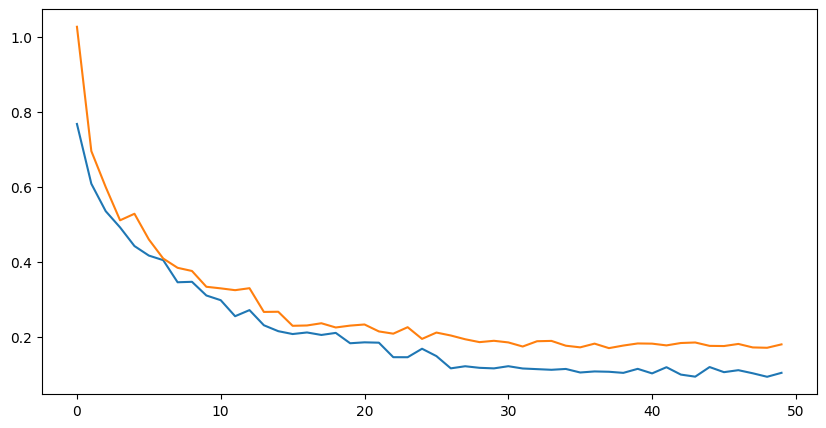

In [13]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list4)
plt.plot(val_losses)

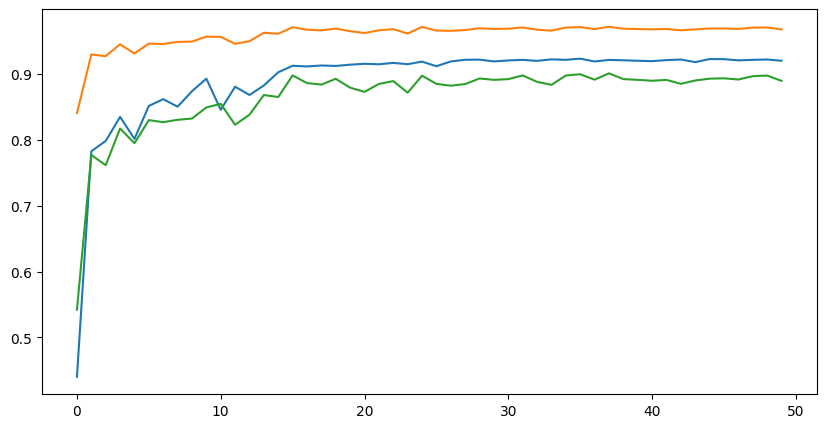

In [14]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list4)
plt.plot(val_accs)
plt.plot(val_mious)